In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
%matplotlib notebook

#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

## Import Data

In [2]:
earnings_path = 'data\\processed\\df_quarter_eps_average_08_09.csv'
key_path = 'data\\external\\quarterly_key_sp_500.csv'

In [3]:
df = pd.read_csv(earnings_path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

In [4]:
df.shape

(528, 2)

In [5]:
df_key = pd.read_csv(key_path)
df_key.index = df_key['symbol']
df_key.drop(['symbol', 'Unnamed: 2'], axis=1, inplace=True)

In [6]:
df_key

,company
symbol,
A,AGILENT TECHNOLOGIES INC
AA,ALCOA INC
AAP,ADVANCE AUTO PARTS INC
AAPL,APPLE
ABBV,ABBVIE INC
...,...
XYL,XYLEM INC
YUM,YUM BRANDS INC
ZMH,ZIMMER BIOMET HOLDINGS INC


## Limit to only SP500 Stocks

#### Quarterly data has stocks outside of SP500, have to consider whether its worth it to keep or not

In [7]:
idx1 = df.index
idx2 = df_key.index

In [8]:
idx_diff1 = idx1.difference(idx2)
idx_diff1

Index(['AAN', 'ABK', 'ACC', 'ACIW', 'ACXM', 'AEO', 'AFG', 'AGCO', 'AHL',
       'AKRX',
       ...
       'VIVO', 'WDR', 'WEN', 'WFT', 'WIN', 'WINA', 'WPI', 'WPO', 'WYN', 'X'],
      dtype='object', length=135)

In [9]:
df.drop(idx_diff1, inplace=True)
df.shape

(393, 2)

## Quick Analysis

In [10]:
df['hypothesis']=np.where(df['Recession EPS']>=df['Average EPS'], 'Candidate', 'Not Candidate')
colors = {'Candidate':'red', 'Not Candidate':'blue'}
df['colors']=df['hypothesis'].apply(lambda x: colors[x])

In [11]:
df_cand = df[df['hypothesis']=='Candidate']
df_not = df[df['hypothesis']=='Not Candidate']

In [12]:
df_cand

,Recession EPS,Average EPS,hypothesis,colors
Stock,,,,
ABT,0.8625,0.575000,Candidate,red
ADSK,0.0625,0.011458,Candidate,red
AEE,0.6675,0.452083,Candidate,red
AES,0.2300,0.032083,Candidate,red
ARE,0.7975,0.432708,Candidate,red
...,...,...,...,...
WEC,0.8175,0.738125,Candidate,red
WLTW,0.5750,0.569583,Candidate,red
WU,0.3250,0.298333,Candidate,red


In [13]:
df_not

,Recession EPS,Average EPS,hypothesis,colors
Stock,,,,
AAPL,1.45250,4.532708,Not Candidate,blue
AAP,0.67000,1.230625,Not Candidate,blue
AA,-0.55500,-0.019542,Not Candidate,blue
ABC,0.70000,0.710417,Not Candidate,blue
ABMD,-0.21000,0.186042,Not Candidate,blue
...,...,...,...,...
XLNX,0.30000,0.511042,Not Candidate,blue
XOM,1.55000,1.555833,Not Candidate,blue
XRX,0.12775,0.167521,Not Candidate,blue


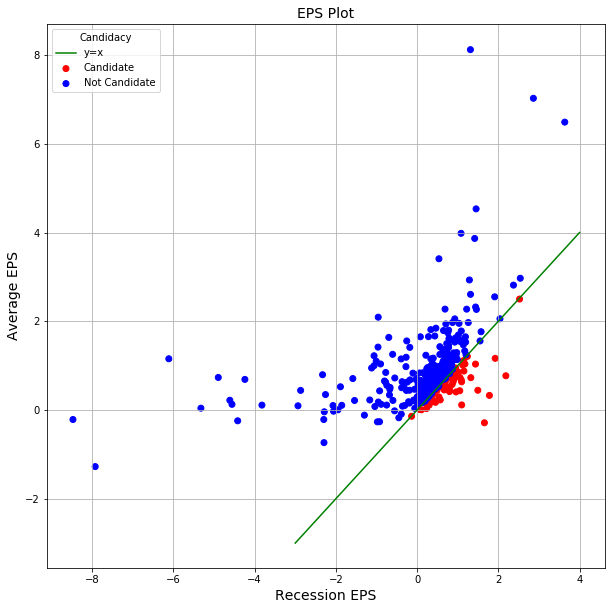

In [14]:
sub_title_font =14
legend_font =8
axis_font = 10
x = np.linspace(-3, 4, 100)
y=x

fig, ax = plt.subplots(1, 1, figsize=(10,10))
cand = ax.scatter(df_cand['Recession EPS'], df_cand['Average EPS'], c=df_cand.colors, label='Candidate')
not_cand = ax.scatter(df_not['Recession EPS'], df_not['Average EPS'], c=df_not.colors, label='Not Candidate')
line = ax.plot(x, y, c="green", label='y=x')

plt.xlabel('Recession EPS', fontsize=sub_title_font)
plt.ylabel('Average EPS', fontsize=sub_title_font)
plt.title('EPS Plot', fontsize=sub_title_font)
ax.tick_params(axis="x", labelsize=axis_font)
ax.tick_params(axis="y", labelsize=axis_font)

plt.grid(which='major')
ax.legend(loc = 'upper left', title='Candidacy')
plt.show()

## Build Portfolio

In [15]:
df_cand

,Recession EPS,Average EPS,hypothesis,colors
Stock,,,,
ABT,0.8625,0.575000,Candidate,red
ADSK,0.0625,0.011458,Candidate,red
AEE,0.6675,0.452083,Candidate,red
AES,0.2300,0.032083,Candidate,red
ARE,0.7975,0.432708,Candidate,red
...,...,...,...,...
WEC,0.8175,0.738125,Candidate,red
WLTW,0.5750,0.569583,Candidate,red
WU,0.3250,0.298333,Candidate,red
